In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import yaml
import json
import sys
import numpy as np
import matplotlib

from matplotlib import ticker
from functools import reduce
# from environment import Statistics
from plot_utils import *

from IPython.display import IFrame

plt.style.use('seaborn-v0_8-paper')

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.size": 10,
          "font.weight": "medium",
          'text.latex.preamble': r'\usepackage{lmodern}',
          "font.family" : "Latin Modern Roman",}


plt.rcParams.update(params)

# matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=[
#     '#03579b', '#0488d1', '#03a9f4', '#4fc3f7', '#b3e5fc', '#253137', '#455a64', '#607d8b', '#90a4ae', '#cfd8dc',
#     '#19237e', '#303f9f', '#3f51b5', '#7986cb', '#c5cae9', '#4a198c', '#7b21a2', '#9c27b0', '#ba68c8', '#e1bee7',
#     '#88144f', '#c21f5b', '#e92663', '#f06292', '#f8bbd0', '#bf360c', '#e64a18', '#ff5722', '#ff8a65', '#ffccbc',
#     '#f67f17', '#fbc02c', '#ffec3a', '#fff177', '#fdf9c3', '#33691d', '#689f38', '#8bc34a', '#aed581', '#ddedc8'
# ])

In [3]:
%load_ext autoreload
%autoreload 2

# Submission

In [4]:
def get_model_index(path):
    return int(path.split('_')[-1].split('.')[0])

def get_parameters(path: str):
    parameters_path = os.path.join(path, 'parameters.yml')
    # is_agent_saved = os.path.exists(os.path.join(path, 'agent'))

    if not os.path.exists(parameters_path): #or not is_agent_saved:
        return None

    with open(parameters_path) as f:
        parameters = yaml.safe_load(f)

    return parameters

def load_models(path, depth, predicate):
    result = []

    if not os.path.exists(path):
        return []

    for directory in os.listdir(path):
        directory_path = os.path.join(path, directory)

        if not os.path.isdir(directory_path):
            continue

        if depth != 0:
            result += load_models(directory_path, depth - 1, predicate)

        parameters = get_parameters(directory_path)

        if parameters is None:
            continue

        if predicate(parameters):
            result += [directory_path]

    return sorted(result, key=lambda x: get_model_index(x))

def load_tournament(path, baseline=None):
    result_path = os.path.join(path, 'result.csv')
    results = pd.read_csv(result_path)
    results['candidate'] = results['candidate'].str.lstrip('_')

    results = results[results['run'].str.contains('_1_')].copy()
    results['run'] = results['run'].apply(lambda x: int(x.split('_')[-1]))

    if baseline is not None:
        results = results.append(baseline)

    return results

def candidates(df):
    return sorted(df['candidate'].unique(), key=lambda x: int(x.split('_')[-1]) if x.split('_')[-1].isnumeric() else -1)

def make_run_path(path, run_id):
    return os.path.join(path, 'run', f'_1_{run_id}', 'machine_reward.csv')

def fetch_rewards(path, run_ids = None):
    rewards = []
    run = 1

    while True:
        try:
            run_path = make_run_path(path, run)
            result = pd.read_csv(run_path)

            result['run'] = run

            if run_ids is None or run in run_ids:
                rewards += [result]

            run += 1
        except:

            break

    return pd.concat(rewards)

class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

In [5]:
scheduling_action_map = [
    'atc', 'avpro', 'covert', 'cr', 'crspt', 'dptlwkr', 'dptlwkrs', 'dptwinqnpt', 'edd', 'fifo',
    'gp1', 'gp2', 'lifo', 'lpt', 'lro', 'lwkr', 'lwkrmod', 'lwkrspt', 'lwt', 'mwkr', 'mdd','mod',
    'mon', 'mro', 'ms', 'npt', 'ptwinq', 'ptwinqs', 'random', 'spmwk', 'spmwkspt', 'spt', 'swt',
    'winq'
]

## Part (0)

### JSP

In [7]:
static_rules = load_tournament('data/0. Rules/run')
static_rules['candidate'] = static_rules['candidate'].str.split('_').apply(lambda x: x[0])
static_rules['candidate'] = static_rules['candidate'].str.extract(r'(.*)SchedulingRule$')

# Duplicate rules to aggregate tournament values
result = []

b = static_rules.copy()
b['run'] += 100

c = static_rules.copy()
c['run'] += 200

result = [
    static_rules.copy(),
    b,
    c
]

static_rules = pd.concat(result)

baseline_rule = 'FIFO'
baseline = static_rules[static_rules['candidate'] == baseline_rule]

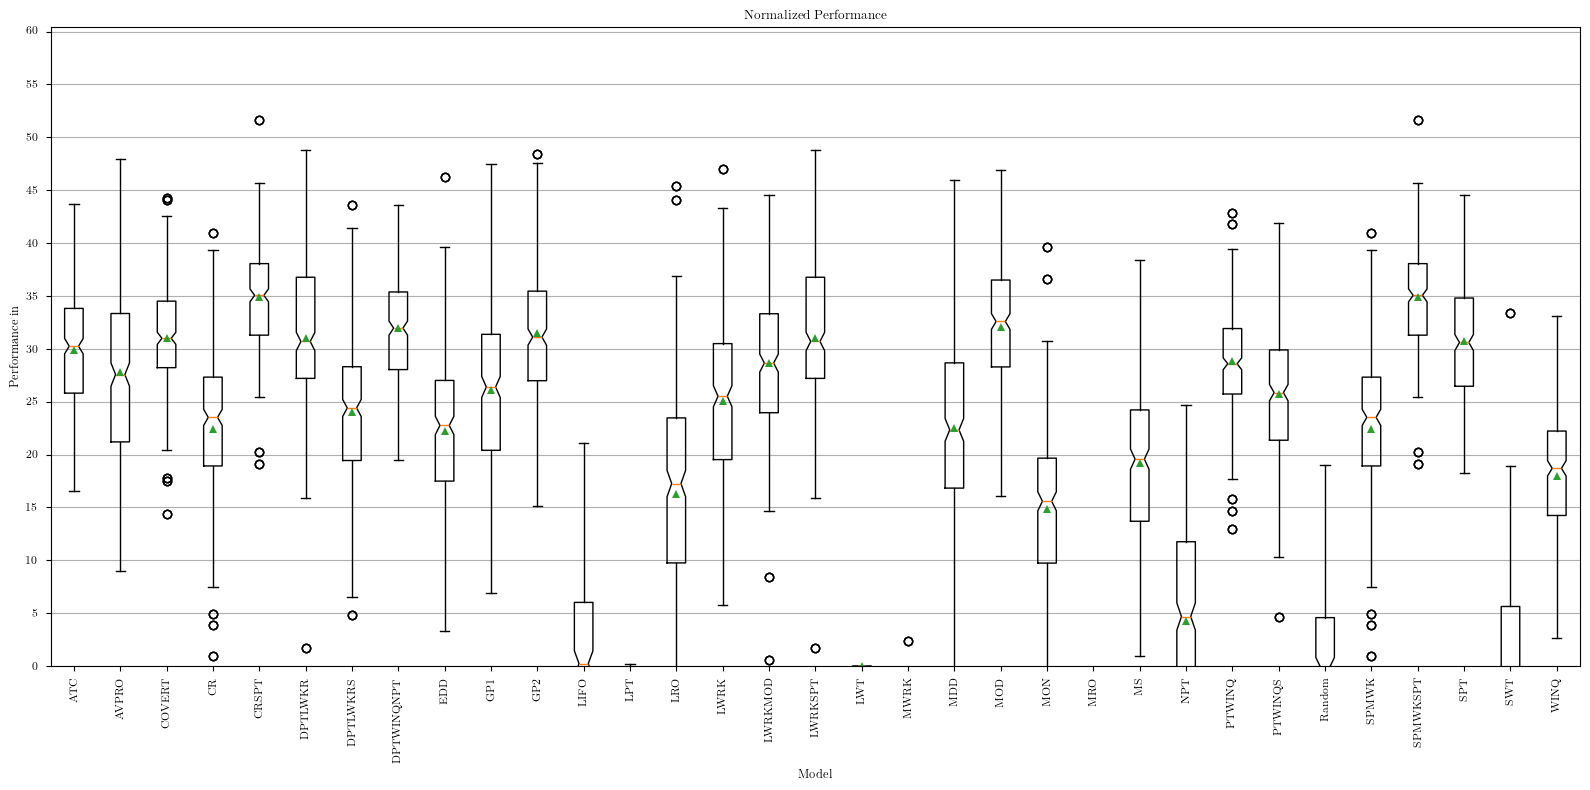

In [8]:
performances = plot_normalized_performance(
    static_rules,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(static_rules),
        baseline='FIFO',
        ncols=1,
        bottom=0,
        box_width=0.4,
       # top_k=20,
        sort=False,
        figsize=(16, 8)
    )
);

<Axes: xlabel='candidate'>

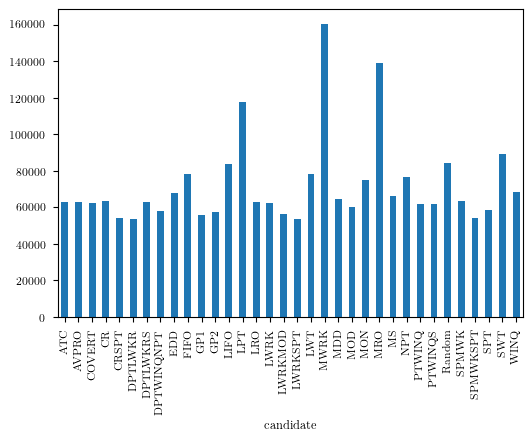

In [9]:
static_rules[static_rules['run'] == 10].set_index('candidate')['tardiness'].plot.bar(figsize=(6, 4))

In [9]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# # The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../Rules/eval/output.tex' )
# ! (cp 'Testing/dataset.csv' 'Rules/eval/output.csv')
# ! (cd 'Rules/eval' && pdflatex -interaction=nonstopmode 'output.tex' > /dev/null)

In [10]:
short = static_rules[static_rules['candidate'].isin(['LWRK', 'CR', 'CRSPT', 'MS', 'SPT', 'WINQ', 'LIFO', 'FIFO'])]

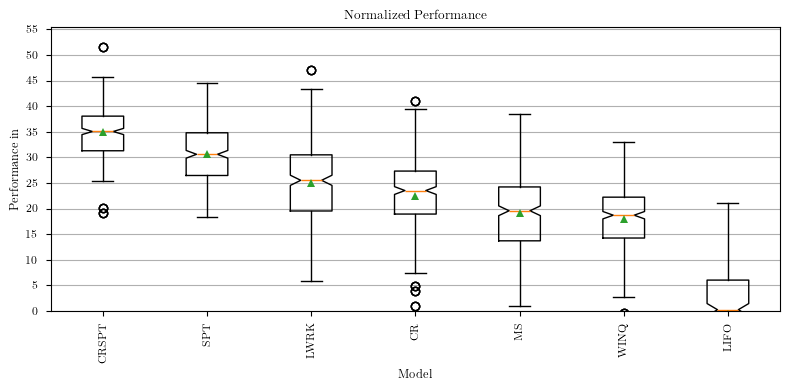

In [11]:
performances = plot_normalized_performance(
    short,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(short),
        baseline='FIFO',
        ncols=1,
        bottom=0,
        box_width=0.4,
#        top_k=20,
        sort=True,
        figsize=(8, 4)
    )
);

In [12]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../Rules/eval/output_short.tex' )
# ! (cp 'Testing/dataset.csv' 'Rules/eval/output_short.csv')
# ! (cd 'Rules/eval' && pdflatex -interaction=nonstopmode 'output_short.tex' > /dev/null)

# Part 1 (DeepMARL)

## Neural Network

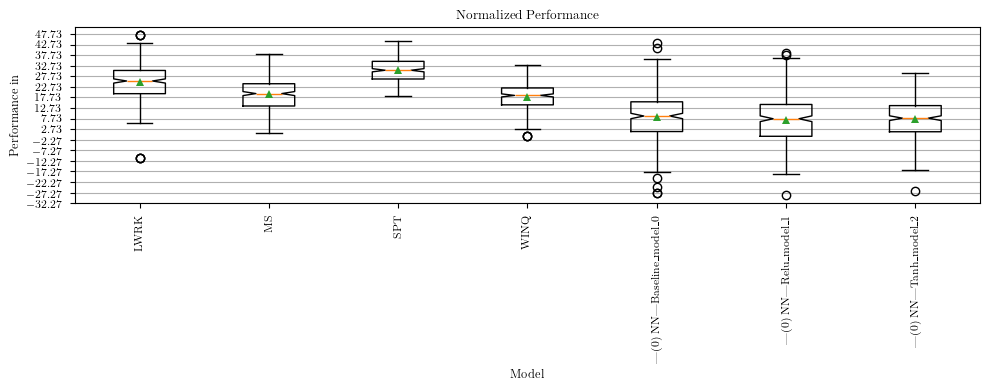

In [13]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/1. MARL/tournament/{i}')
    t['run'] += 100 * i
    return t


tournament = [load_tournament_from_id(i) for i in range(3)]
tournament = pd.concat(tournament)

sub_models = tournament[tournament['candidate'].str.match('(\|\(0\).*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO'])]])
#sub_models.candidate = sub_models['candidate'].apply(lambda x: x.split('|')[-1] if '|' in x else x)
#sub_models.candidate = sub_models['candidate'].apply(lambda x: x.split('_')[0] + ' ' + ('(SARL)' if get_model_index(x) % 2 == 0 else '(MARL)')  if '_' in x else x)

#sub_models = sub_models[sub_models.candidate.apply(lambda x:get_model_index(x) % 2 == 0 if '_' in x else True)]
#sub_models.candidate = sub_models['candidate'].apply(lambda x: x.split('_')[0]  if '_' in x else x)

baseline = sub_models

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=-10,
        sort=False,
        # bbox_to_anchor =
        figsize=(10, 4)
    ),
    # ax=axes[1]
)

In [16]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../MARL/eval/output_nn.tex' )
# ! (cp 'Testing/dataset.csv' 'MARL/eval/output_nn.csv')
# ! (cd 'MARL/eval' && pdflatex -interaction=nonstopmode 'output_nn.tex' > /dev/null)

## Optimizer

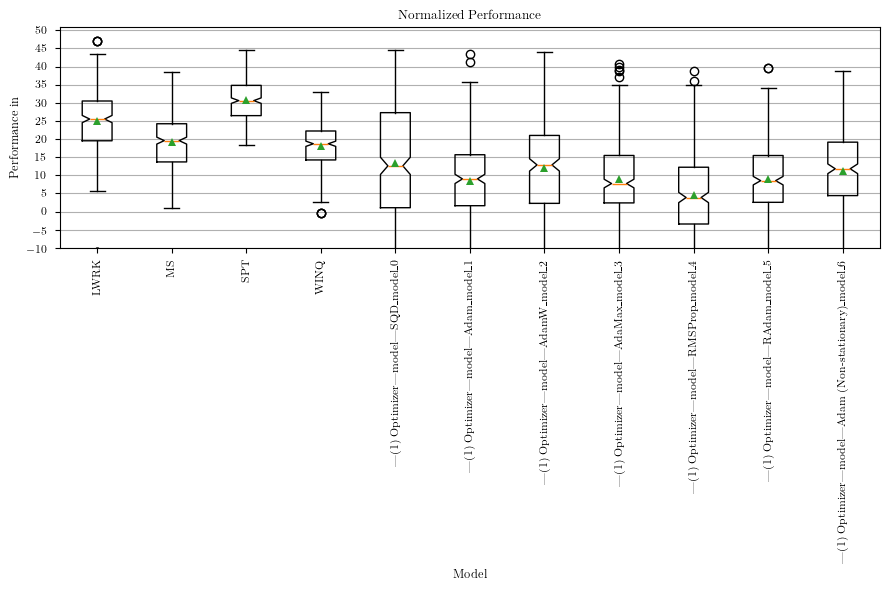

In [14]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/1. MARL/tournament/{i}')
    t['run'] += 100 * i
    return t


tournament = [load_tournament_from_id(i) for i in range(3)]
tournament = pd.concat(tournament)

sub_models = tournament[tournament['candidate'].str.match('(\|\(1\).*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO'])]])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        bottom=-10,
        sort=False,
        # bbox_to_anchor =
        figsize=(9, 6)
    ),
    # ax=axes[1]
)

In [20]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../MARL/eval/output_optimizer.tex' )
# ! (cp 'Testing/dataset.csv' 'MARL/eval/output_optimizer.csv')
# ! (cd 'MARL/eval' && pdflatex -interaction=nonstopmode 'output_optimizer.tex' > /dev/null)

## Initialization

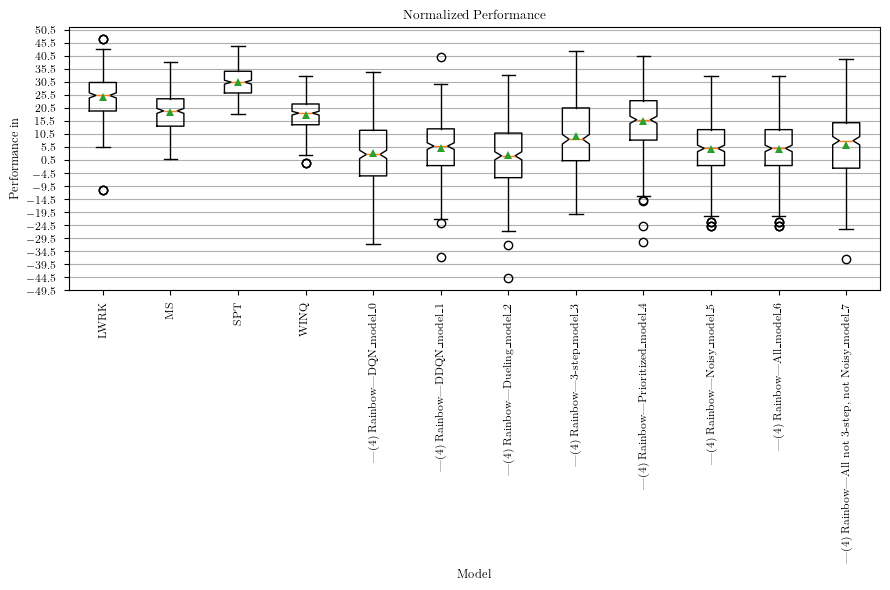

In [15]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/1. MARL/tournament/{i}')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in range(3)]
tournament = pd.concat(tournament)

sub_models = tournament[tournament['candidate'].str.match('(\|\(4\).*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO'])]])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=-10,
        sort=False,
        # bbox_to_anchor =
        figsize=(9, 6)
    ),
    # ax=axes[1]
)

In [24]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../MARL/eval/output_initializer.tex' )
# ! (cp 'Testing/dataset.csv' 'MARL/eval/output_initializer.csv')
# ! (cd 'MARL/eval' && pdflatex -interaction=nonstopmode 'output_initializer.tex' > /dev/null)

### AS 

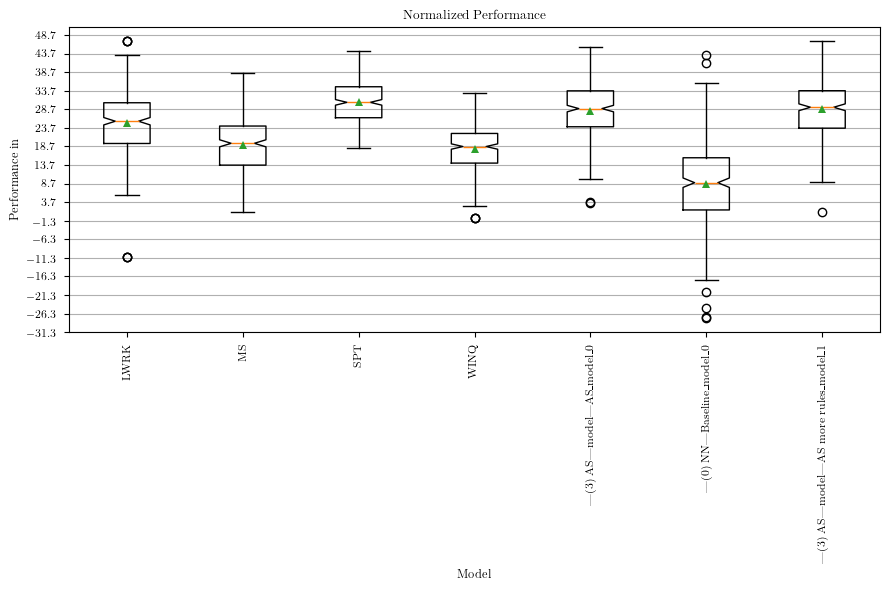

In [16]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/1. MARL/tournament/{i}')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in range(3)]
tournament = pd.concat(tournament)

sub_models = tournament[tournament['candidate'].str.match('(\|\(3\).*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO'])]])

sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=-10,
        sort=False,
        # bbox_to_anchor =
        figsize=(9, 6)
    ),
    # ax=axes[1]
)

In [29]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../MARL/eval/output_as.tex' )
# ! (cp 'Testing/dataset.csv' 'MARL/eval/output_as.csv')
# ! (cd 'MARL/eval' && pdflatex -interaction=nonstopmode 'output_as.tex' > /dev/null)

### Rainbow

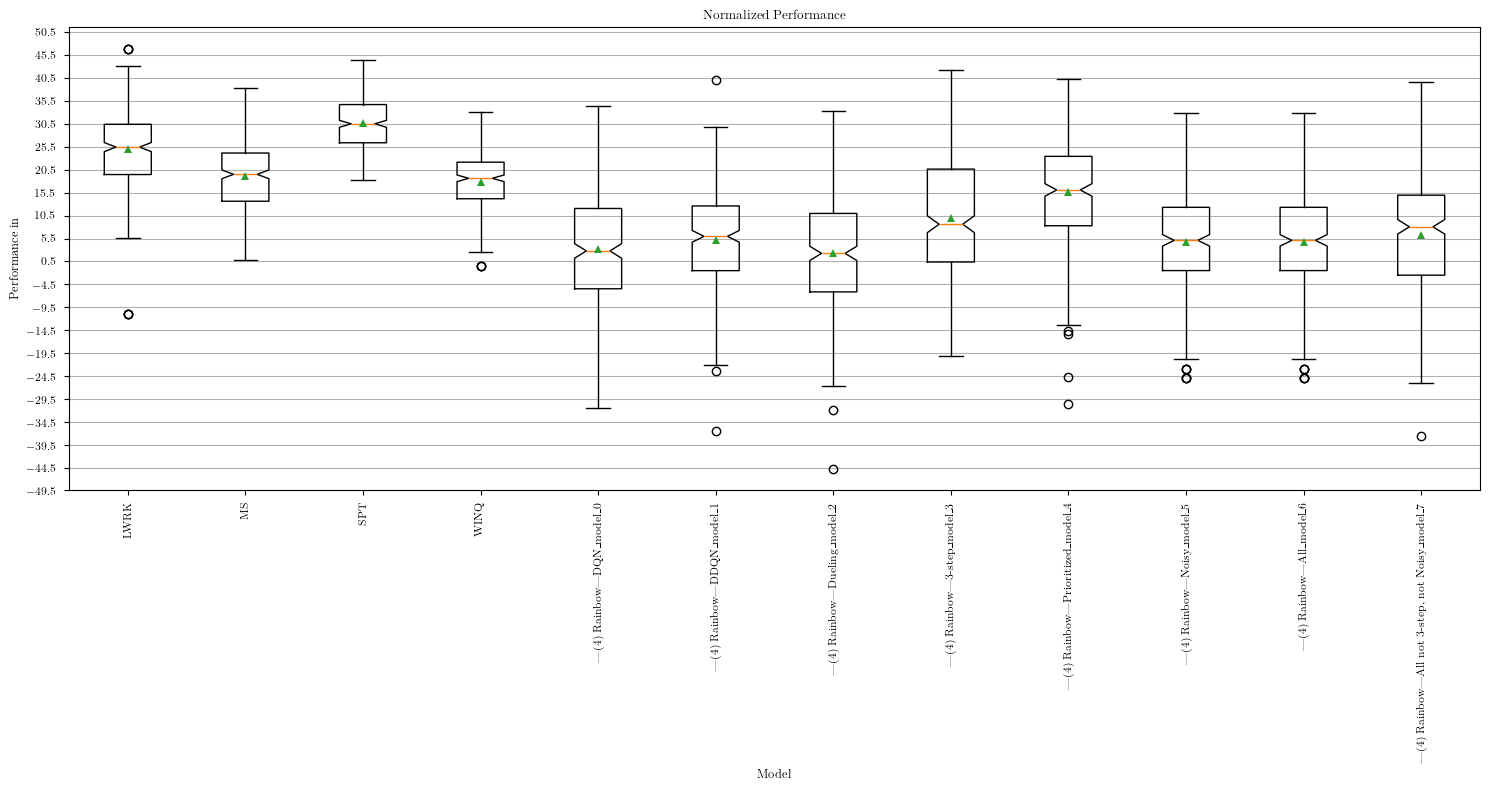

In [17]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/1. MARL/tournament/{i}')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in range(3)]
tournament = pd.concat(tournament)

sub_models = tournament[tournament['candidate'].str.match('(\|\(4\).*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO'])]])

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=-10,
        sort=False,
        # bbox_to_anchor =
        figsize=(15, 8)
    ),
    # ax=axes[1]
)

In [35]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../MARL/eval/output_rainbow.tex' )
# ! (cp 'Testing/dataset.csv' 'MARL/eval/output_rainbow.csv')
# ! (cd 'MARL/eval' && pdflatex -interaction=nonstopmode 'output_rainbow.tex' > /dev/null)

## Reward

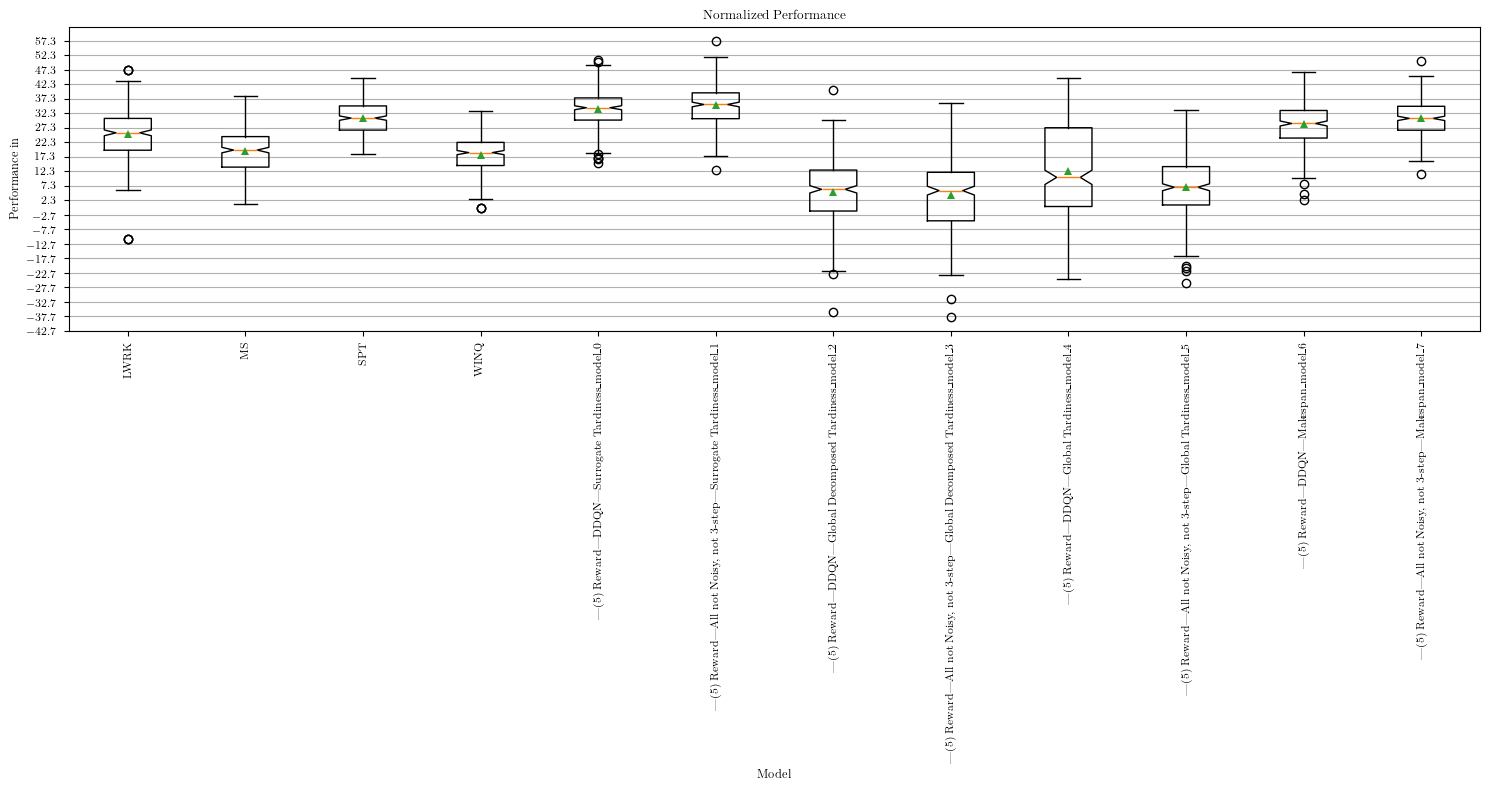

In [18]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/1. MARL/tournament/{i}')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in range(3)]
tournament = pd.concat(tournament)

sub_models = tournament[tournament['candidate'].str.match('(\|\(5\).*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO'])]])

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=-10,
        sort=False,
        # bbox_to_anchor =
        figsize=(15, 8)
    ),
    # ax=axes[1]
)

plt.show()

## PPO

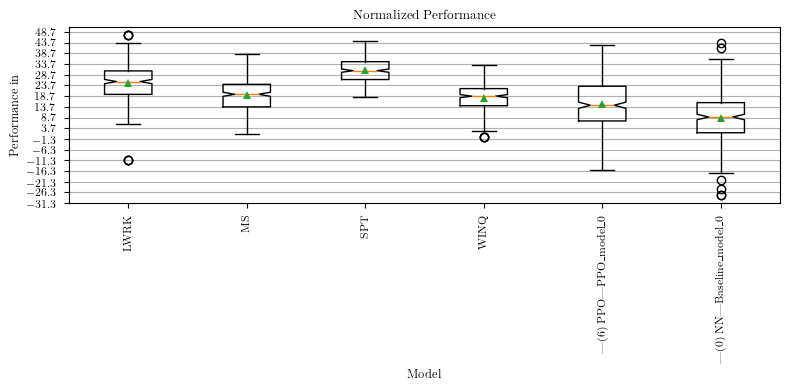

In [23]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/1. MARL/tournament/{i}')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in range(3)]
tournament = pd.concat(tournament)

sub_models = tournament[tournament['candidate'].str.match('(\|\(6\).*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO'])]])

sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=-10,
        sort=False,
        # bbox_to_anchor =
        figsize=(8, 4)
    ),
    # ax=axes[1]
)

plt.show()

In [48]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../MARL/eval/output_ppo.tex' )
# ! (cp 'Testing/dataset.csv' 'MARL/eval/output_ppo.csv')
# ! (cd 'MARL/eval' && pdflatex -interaction=nonstopmode 'output_ppo.tex' > /dev/null)

# Part 2 (Graph-NN)

## 1. Flexible DQN

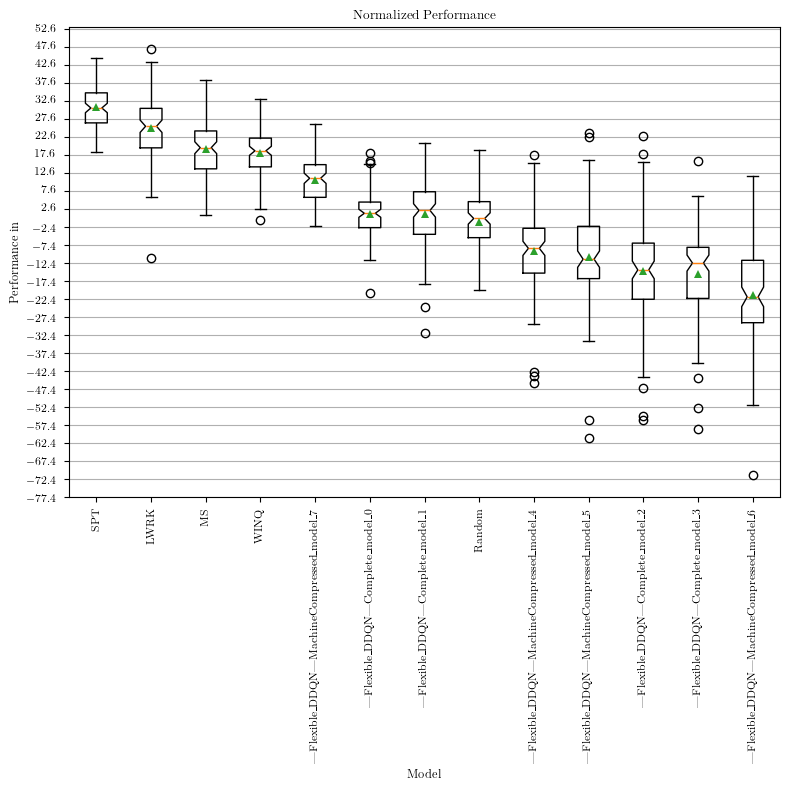

In [26]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/2. Graph/tournament/{i}')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in [0]]
tournament = pd.concat(tournament)

tournament

sub_models = tournament[tournament['candidate'].str.match('(\|Flexible_DDQN.*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO', 'Random'])]])

sub_models = sub_models[sub_models['run'] <= 100]

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=0,
        sort=True,
        # bbox_to_anchor =
        figsize=(8, 8)
    ),
    # ax=axes[1]
)

In [52]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     if len(candidate) == 100:
#         name = name.replace('_', '-').replace(',', '')
#         df[name] = candidate

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()


# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../GRAPH-NN/eval/output_all.tex' )
# ! (cp 'Testing/dataset.csv' 'GRAPH-NN/eval/output_all.csv')
# ! (cd 'GRAPH-NN/eval' && pdflatex -interaction=nonstopmode 'output_all.tex' > /dev/null)

## 2. Flexible PPO

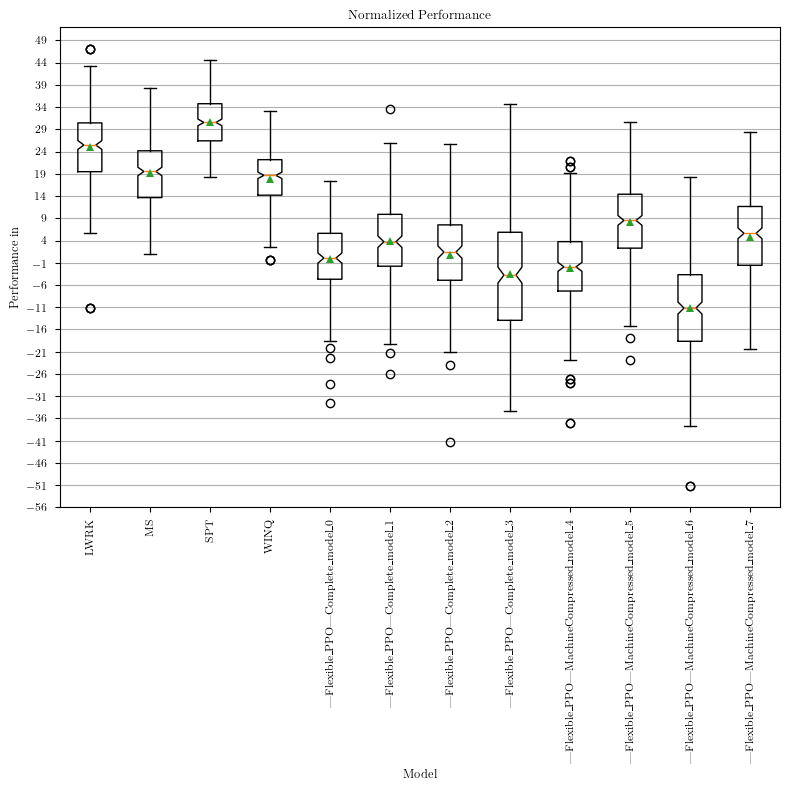

In [27]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/2. Graph/tournament/{i}')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in range(3)]
tournament = pd.concat(tournament)

tournament

sub_models = tournament[tournament['candidate'].str.match('(\|Flexible_PPO.*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO'])]])

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=0,
        sort=False,
        # bbox_to_anchor =
        figsize=(8, 8)
    ),
    # ax=axes[1]
)

In [58]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     if len(candidate) == 300:
#         name = name.replace('_', '-').replace(',', '')
#         df[name] = candidate

# print(df)

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../GRAPH-NN/eval/output_flexible_ppo.tex' )
# ! (cp 'Testing/dataset.csv' 'GRAPH-NN/eval/output_flexible_ppo.csv')
# ! (cd 'GRAPH-NN/eval' && pdflatex -interaction=nonstopmode 'output_flexible_ppo.tex' > /dev/null)

## 3. Rules DDQN

/var/folders/n9/dd1zbx092b72sp00gqg2y5bw0000gp/T/ipykernel_81552/2077798304.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  t['candidate'] = t['candidate'].str.replace('\|Model\|', '|')
/var/folders/n9/dd1zbx092b72sp00gqg2y5bw0000gp/T/ipykernel_81552/2077798304.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  t['candidate'] = t['candidate'].str.replace('\|model\|', '|')


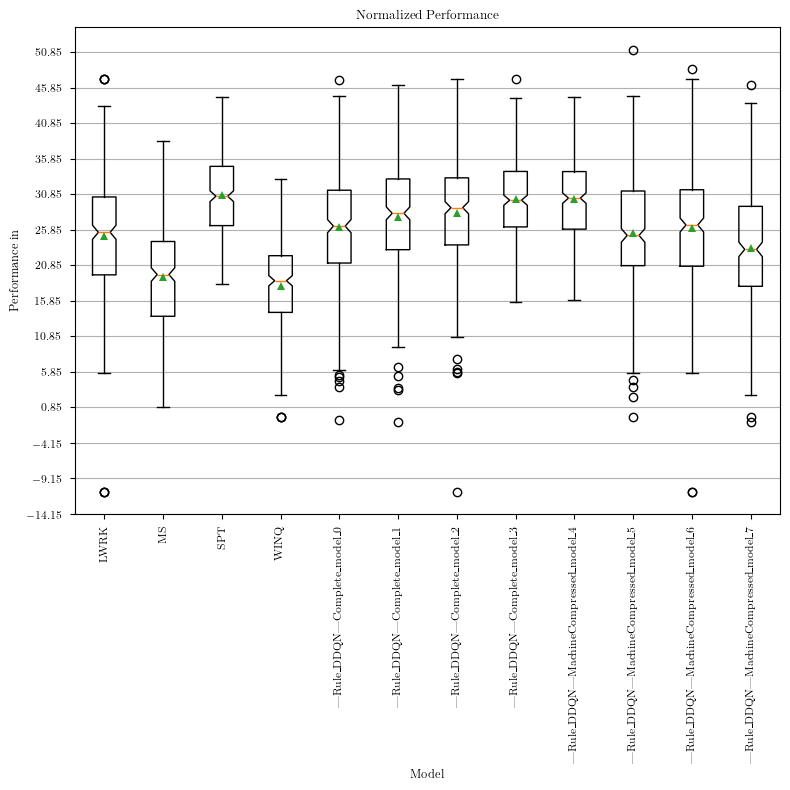

In [28]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/2. Graph/tournament/{i}')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['candidate'] = t['candidate'].str.replace('\|Model\|', '|')
    t['candidate'] = t['candidate'].str.replace('\|model\|', '|')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in range(3)]
tournament = pd.concat(tournament)

tournament

sub_models = tournament[tournament['candidate'].str.match('(\|Rule_DDQN.*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO'])]])

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=0,
        sort=False,
        # bbox_to_anchor =
        figsize=(8, 8)
    ),
    # ax=axes[1]
)

In [64]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     if len(candidate) == 300:
#         name = name.replace('_', '-').replace(',', '')
#         df[name] = candidate


# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../GRAPH-NN/eval/output_rule_ddqn.tex' )
# ! (cp 'Testing/dataset.csv' 'GRAPH-NN/eval/output_rule_ddqn.csv')
# ! (cd 'GRAPH-NN/eval' && pdflatex -interaction=nonstopmode 'output_rule_ddqn.tex' > /dev/null)

## 4. Rules PPO

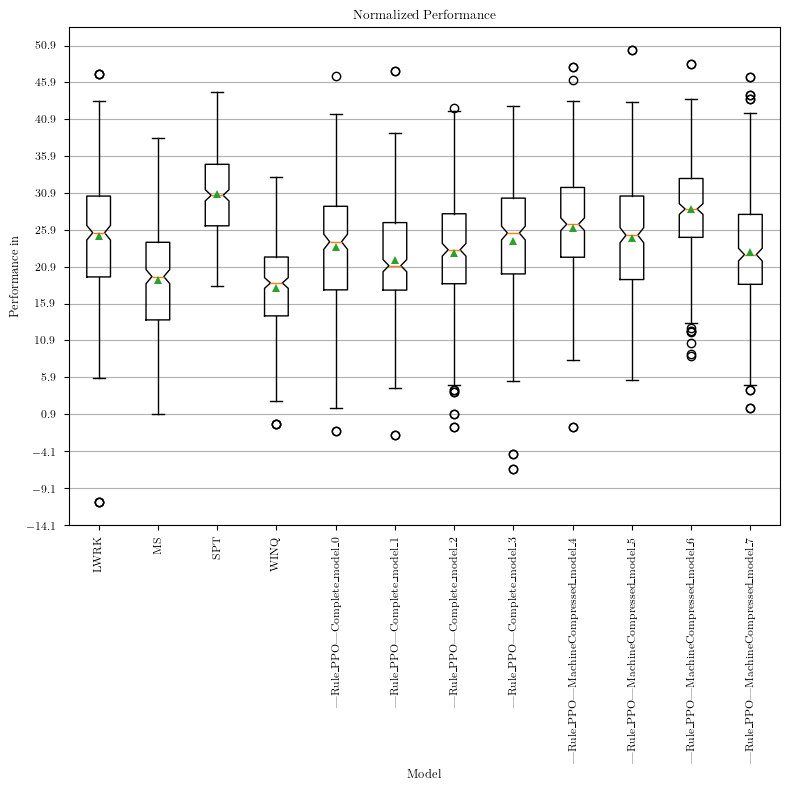

In [29]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/2. Graph/tournament/{i}')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in range(3)]
tournament = pd.concat(tournament)

tournament

sub_models = tournament[tournament['candidate'].str.match('(\|Rule_PPO.*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO'])]])

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=0,
        sort=False,
        # bbox_to_anchor =
        figsize=(8, 8)
    ),
    # ax=axes[1]
)

In [70]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     if len(candidate) == 300:
#         name = name.replace('_', '-').replace(',', '')
#         df[name] = candidate


# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../GRAPH-NN/eval/output_rule_ppo.tex' )
# ! (cp 'Testing/dataset.csv' 'GRAPH-NN/eval/output_rule_ppo.csv')
# ! (cd 'GRAPH-NN/eval' && pdflatex -interaction=nonstopmode 'output_rule_ppo.tex' > /dev/null)

## Best

In [30]:
target_models = [
    '|Rule_DDQN|MachineCompressed_model_4',
    '|Rule_DDQN|Complete_model_1',
    '|Rule_PPO|MachineCompressed_model_6',
    '|Rule_PPO|Complete_model_3',
    '|Flexible_DDQN|MachineCompressed_model_7',
    '|Flexible_DDQN|Complete_model_0',
    '|Flexible_PPO|Complete_model_1',
    '|Flexible_PPO|Complete_model_3'
]

['|Flexible_DDQN|Complete_model_3' '|Flexible_DDQN|Complete_model_2'
 '|Flexible_DDQN|Complete_model_0' '|Flexible_DDQN|Complete_model_1'
 '|Flexible_DDQN|MachineCompressed_model_4'
 '|Flexible_DDQN|MachineCompressed_model_5'
 '|Flexible_DDQN|MachineCompressed_model_7'
 '|Flexible_DDQN|MachineCompressed_model_6' '|Rule_DDQN|Complete_model_3'
 '|Rule_DDQN|Complete_model_2' '|Rule_DDQN|Complete_model_0'
 '|Rule_DDQN|Complete_model_1' '|Rule_DDQN|MachineCompressed_model_4'
 '|Rule_DDQN|MachineCompressed_model_5'
 '|Rule_DDQN|MachineCompressed_model_7'
 '|Rule_DDQN|MachineCompressed_model_6' '|Rule_PPO|Complete_model_3'
 '|Rule_PPO|Complete_model_2' '|Rule_PPO|Complete_model_0'
 '|Rule_PPO|Complete_model_1' '|Rule_PPO|MachineCompressed_model_4'
 '|Rule_PPO|MachineCompressed_model_5'
 '|Rule_PPO|MachineCompressed_model_7'
 '|Rule_PPO|MachineCompressed_model_6' '|Flexible_PPO|Complete_model_3'
 '|Flexible_PPO|Complete_model_2' '|Flexible_PPO|Complete_model_0'
 '|Flexible_PPO|Complete_model_1

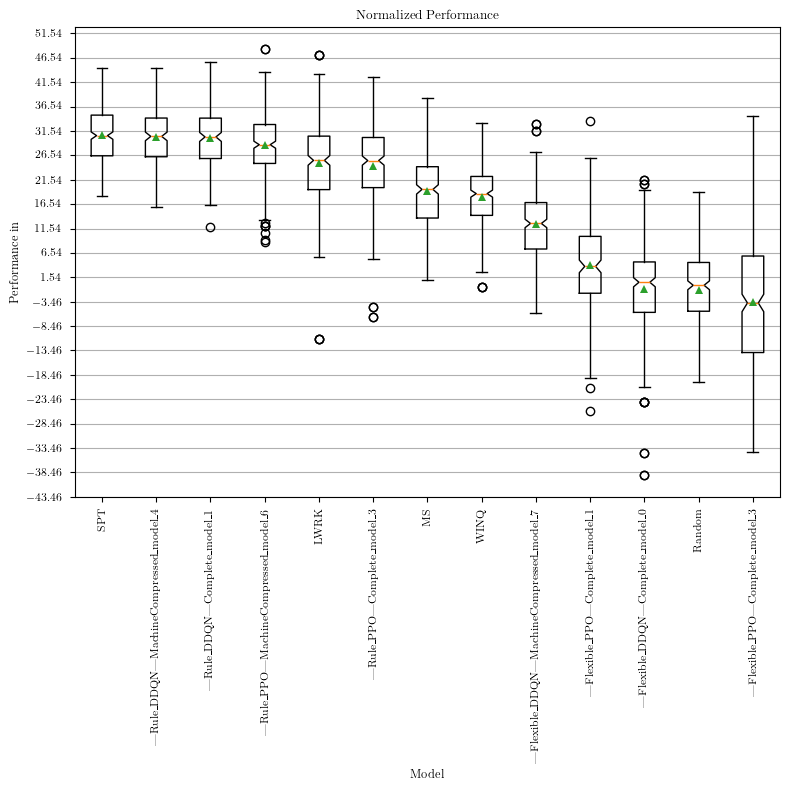

In [31]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/2. Graph/tournament/{i}')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in range(3)]
tournament = pd.concat(tournament)

print(tournament.candidate.unique())

sub_models = tournament[tournament['candidate'].isin(target_models)].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO', 'Random'])]])

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=0,
        sort=True,
        # bbox_to_anchor =
        figsize=(8, 8)
    ),
    # ax=axes[1]
)

In [73]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# df = df[:100]

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../GRAPH-NN/eval/output_final.tex' )
# ! (cp 'Testing/dataset.csv' 'GRAPH-NN/eval/output_final.csv')
# ! (cd 'GRAPH-NN/eval' && pdflatex -interaction=nonstopmode 'output_final.tex' > /dev/null)

# Final

## MARL-DQN

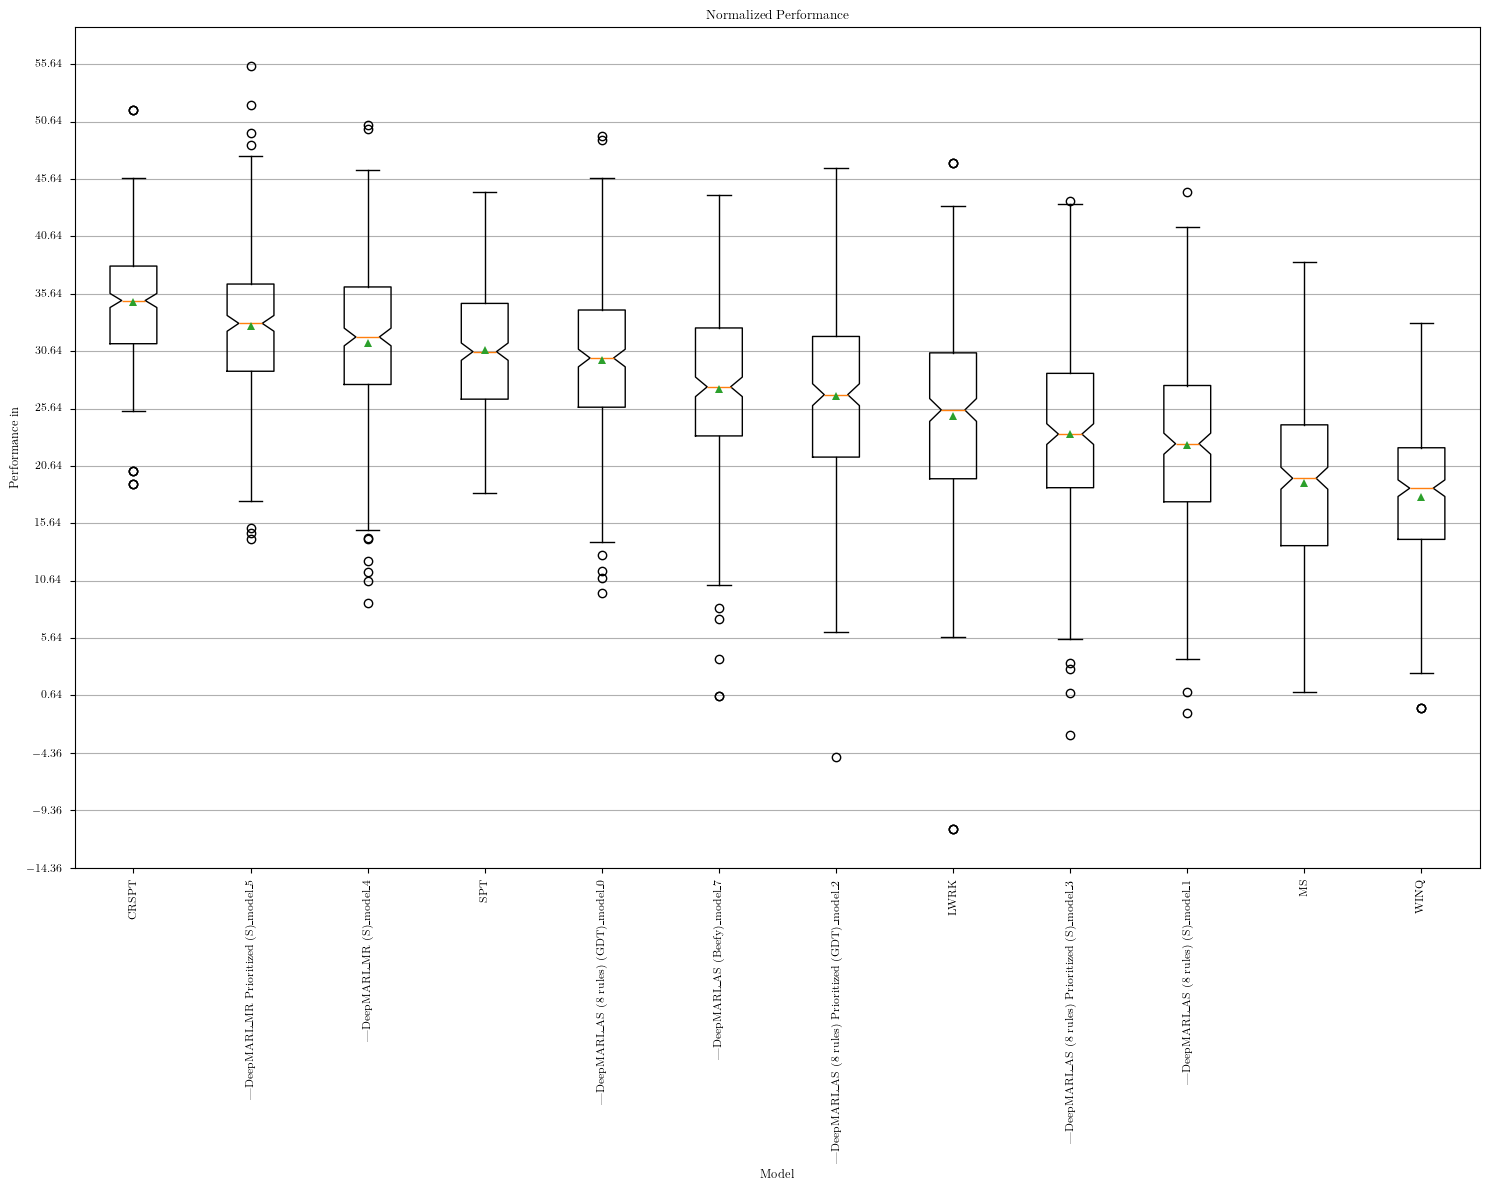

In [38]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/3. Final/MARL-DQN/tournament/{i}/rules')
    t['run'] += 100 * (i - 1)
    return t

tournament = [load_tournament_from_id(i) for i in [1, 2, 3]]
tournament = pd.concat(tournament)

sub_models = tournament
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['CRSPT', 'WINQ', 'MS', 'SPT', 'LWRK', 'FIFO'])]])

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=-10,
        sort=True,
        # bbox_to_anchor =
        figsize=(15, 12)
    ),
    # ax=axes[1]
)

In [78]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../Final/MARL-DQN/eval/output.tex' )
# ! (cp 'Testing/dataset.csv' 'Final/MARL-DQN/eval/output.csv')
# ! (cd 'Final/MARL-DQN/eval' && pdflatex -interaction=nonstopmode 'output.tex' > /dev/null)

## MARL-PPO

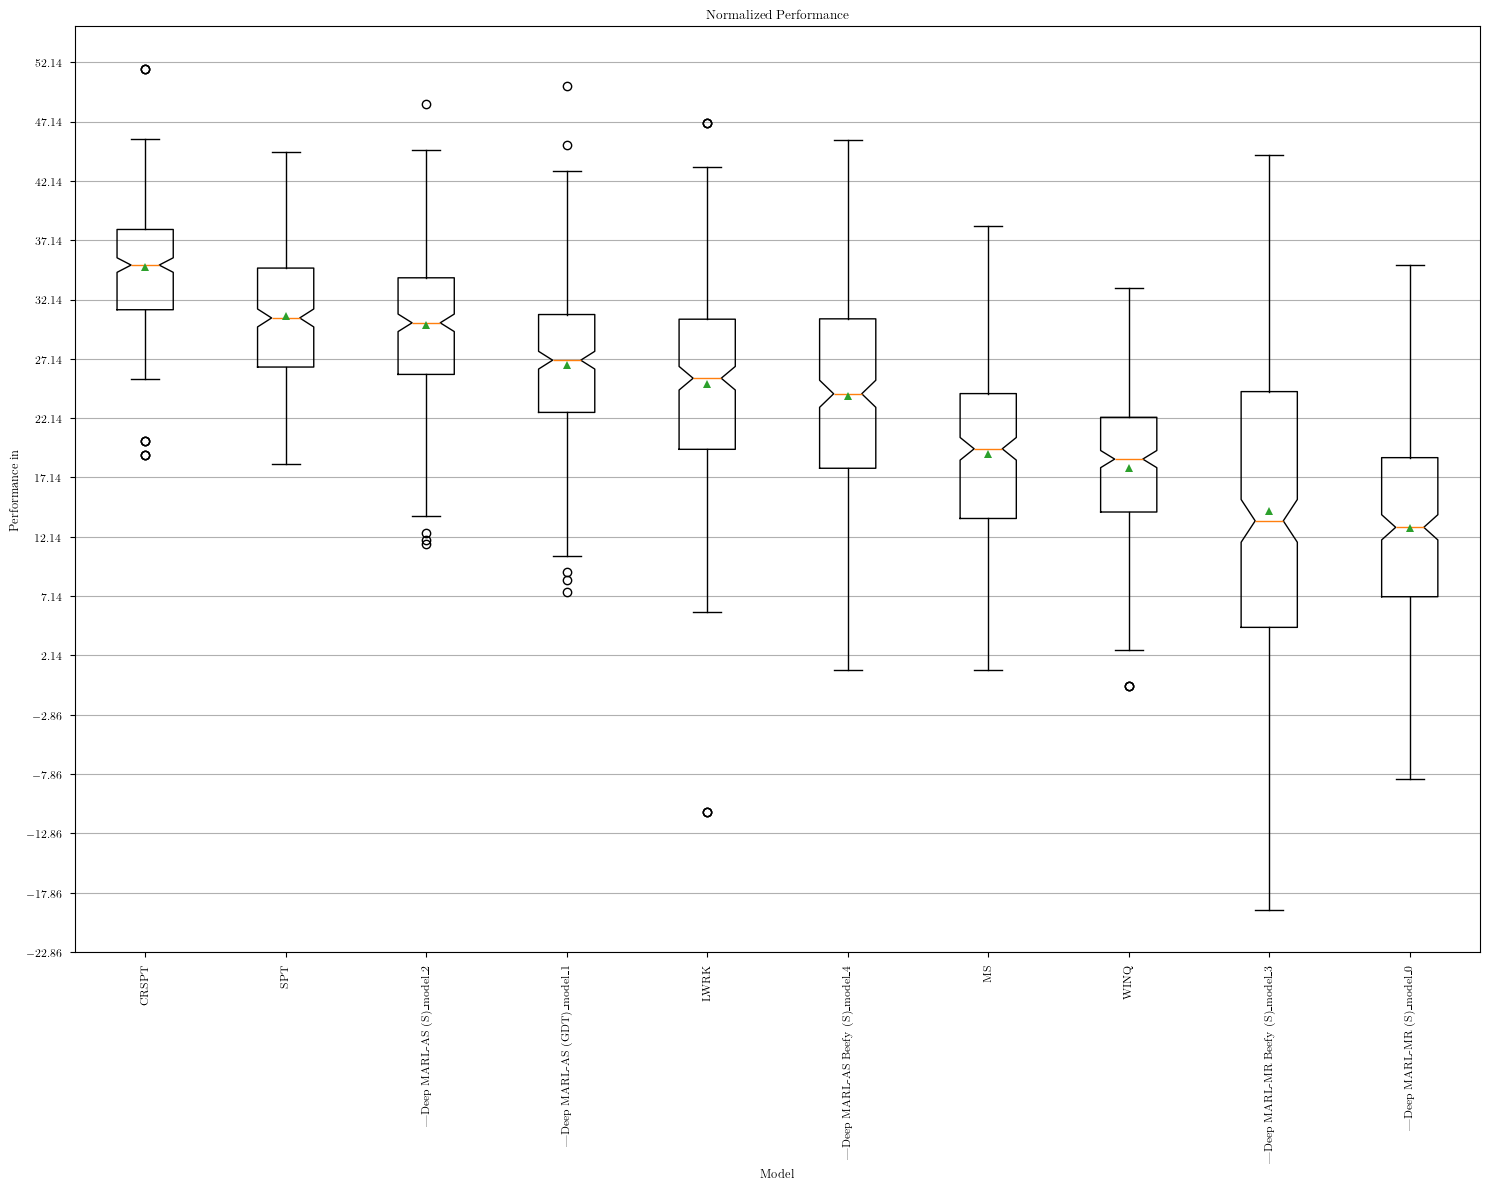

In [39]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/3. Final/MARL-PPO/tournament/{i}/rules')
    t['run'] += 100 * (i - 1)
    return t

tournament = [load_tournament_from_id(i) for i in [1, 2, 3]]
tournament = pd.concat(tournament)

sub_models = tournament
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['CRSPT', 'WINQ', 'MS', 'SPT', 'LWRK', 'FIFO'])]])

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=-10,
        sort=True,
        # bbox_to_anchor =
        figsize=(15, 12)
    ),
    # ax=axes[1]
)

In [84]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../Final/MARL-PPO/eval/output.tex' )
# ! (cp 'Testing/dataset.csv' 'Final/MARL-PPO/eval/output.csv')
# ! (cd 'Final/MARL-PPO/eval' && pdflatex -interaction=nonstopmode 'output.tex' > /dev/null)

## Flexible DDQN

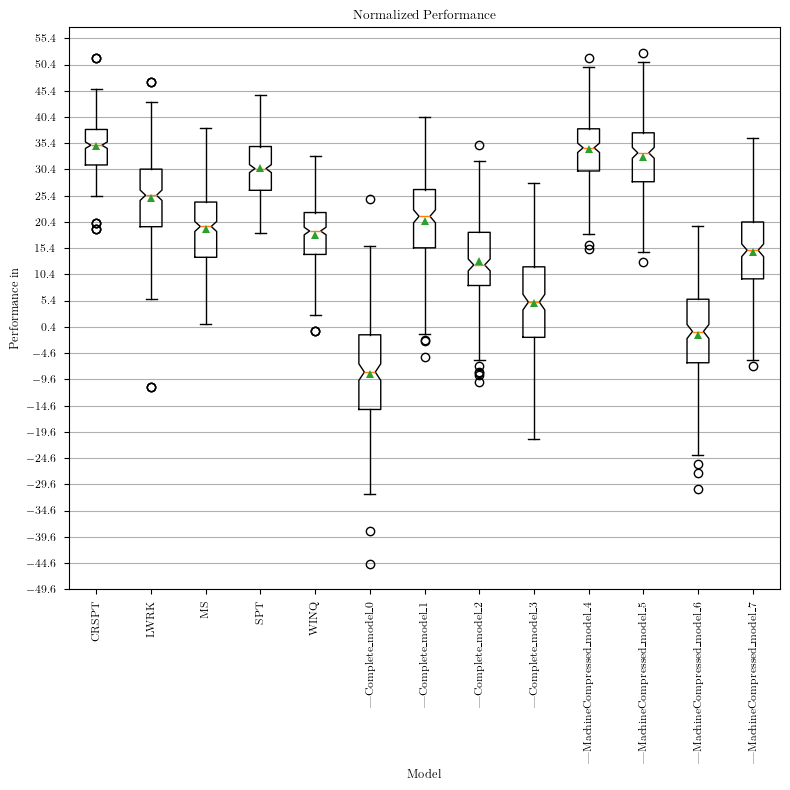

In [41]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/3. Final/Flexible-DDQN/tournament/{i}/rules')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in [1, 2, 3]]
tournament = pd.concat(tournament)

tournament

sub_models = tournament#[tournament['candidate'].str.match('(\|Flexible_DDQN.*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO', 'CRSPT'])]])

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=0,
        sort=False,
        # bbox_to_anchor =
        figsize=(8, 8)
    ),
    # ax=axes[1]
)

## Flexible-PPO

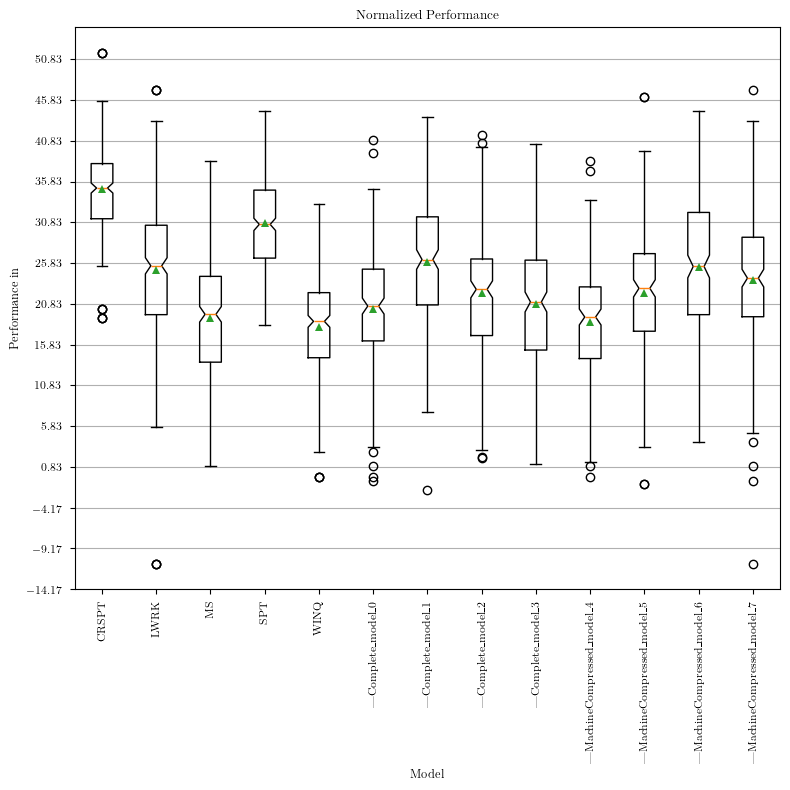

In [42]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/3. Final/Flexible-PPO/tournament/{i}/rules')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in [1, 2, 3]]
tournament = pd.concat(tournament)

tournament

sub_models = tournament#[tournament['candidate'].str.match('(\|Flexible_DDQN.*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO', 'CRSPT'])]])

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=0,
        sort=False,
        # bbox_to_anchor =
        figsize=(8, 8)
    ),
    # ax=axes[1]
)

## Rules-DDQN

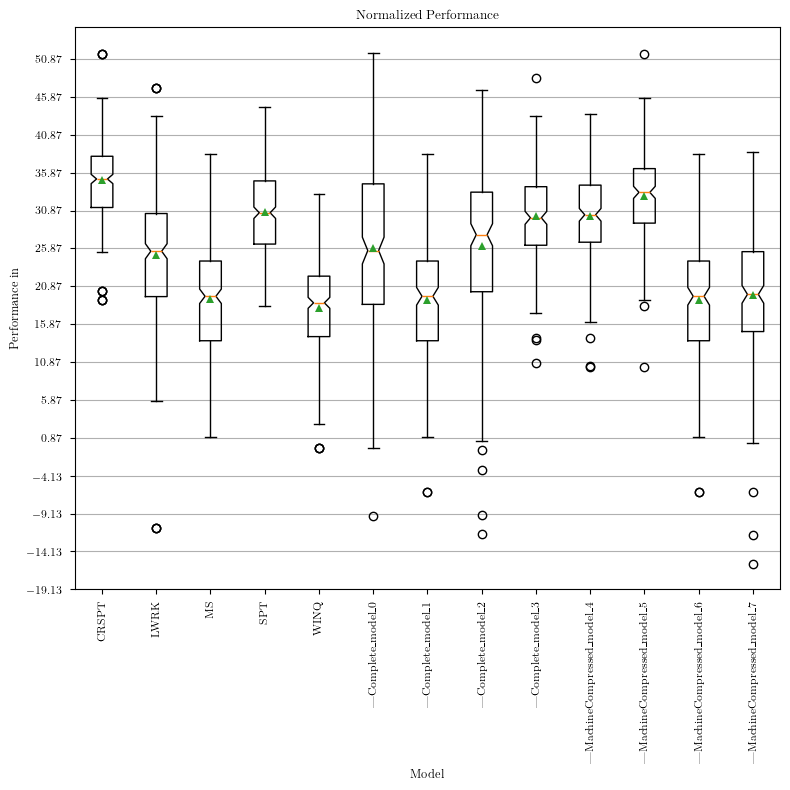

In [46]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/3. Final/Rules-DQN/tournament/{i}/rules')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in [1, 2, 3]]
tournament = pd.concat(tournament)

tournament

sub_models = tournament#[tournament['candidate'].str.match('(\|Flexible_DDQN.*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO', 'CRSPT'])]])

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=0,
        sort=False,
        # bbox_to_anchor =
        figsize=(8, 8)
    ),
    # ax=axes[1]
)

## Rules-PPO

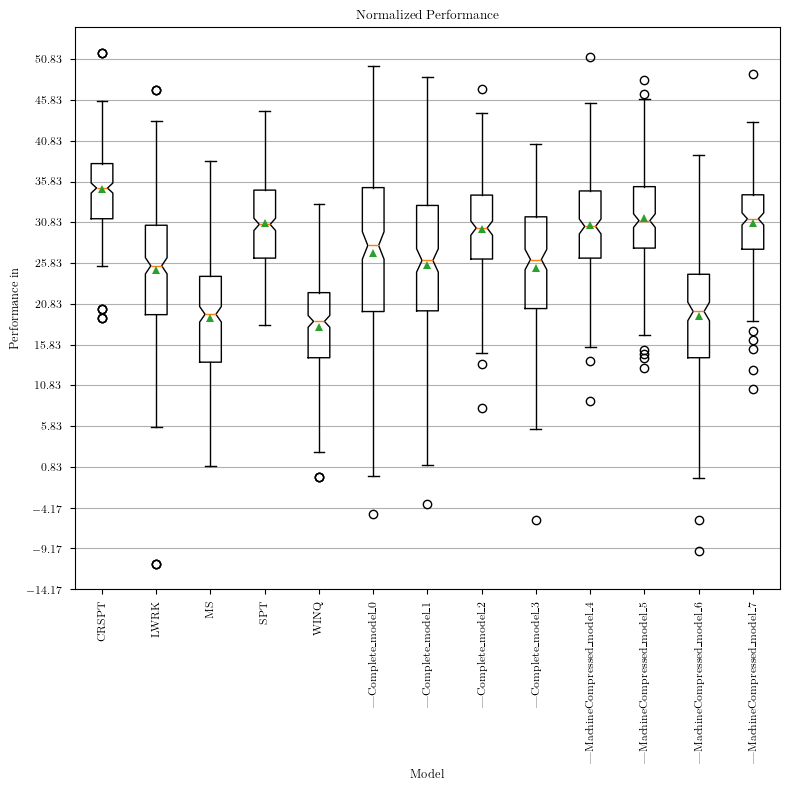

In [47]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/3. Final/Rules-PPO/tournament/{i}/rules')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['run'] += 100 * i
    return t

tournament = [load_tournament_from_id(i) for i in [1, 2, 3]]
tournament = pd.concat(tournament)

tournament

sub_models = tournament#[tournament['candidate'].str.match('(\|Flexible_DDQN.*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO', 'CRSPT'])]])

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=0,
        sort=False,
        # bbox_to_anchor =
        figsize=(8, 8)
    ),
    # ax=axes[1]
)

## Best GNN

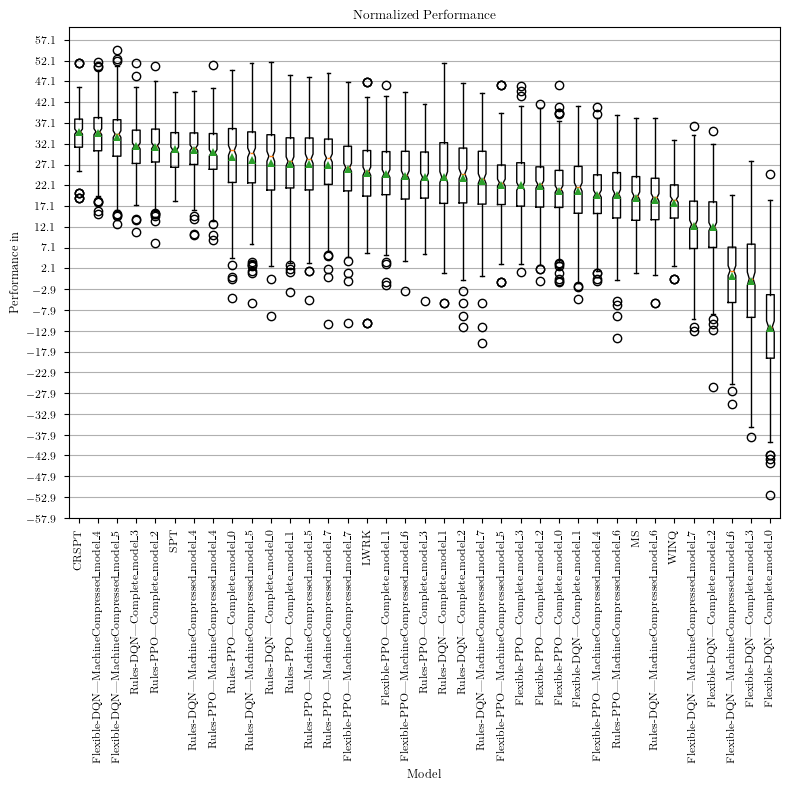

In [50]:
def load_tournament_from_a(i):
    t = load_tournament(f'data/3. Final/Flexible-DDQN/tournament/{i}/rules')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['candidate'] = 'Flexible-DQN' + t['candidate']
    t['run'] += 100 * (i - 1)
    return t

def load_tournament_from_b(i):
    t = load_tournament(f'data/3. Final/Flexible-PPO/tournament/{i}/rules')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['candidate'] = 'Flexible-PPO' + t['candidate']
    t['run'] += 100 * (i - 1)
    return t

def load_tournament_from_c(i):
    t = load_tournament(f'data/3. Final/Rules-DQN/tournament/{i}/rules')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['candidate'] = 'Rules-DQN' + t['candidate']
    t['run'] += 100 * (i - 1)
    return t

def load_tournament_from_d(i):
    t = load_tournament(f'data/3. Final/Rules-PPO/tournament/{i}/rules')
    t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    t['candidate'] = t['candidate'].str.replace('Global', 'Complete')
    t['candidate'] = 'Rules-PPO' + t['candidate']
    t['run'] += 100 * (i - 1)
    return t

tournament_a = [load_tournament_from_a(i) for i in [1, 2, 3]]
tournament_b = [load_tournament_from_b(i) for i in [1, 2, 3]]
tournament_c = [load_tournament_from_c(i) for i in [1, 2, 3]]
tournament_d = [load_tournament_from_d(i) for i in [1, 2, 3]]

tournament = pd.concat(tournament_a + tournament_b + tournament_c + tournament_d)

sub_models = tournament#[tournament['candidate'].str.match('(\|Flexible_DDQN.*)')].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO', 'CRSPT'])]])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=0,
        sort=True,
        # bbox_to_anchor =
        figsize=(8, 8)
    ),
    # ax=axes[1]
)

In [99]:
# df = pd.DataFrame()

# for name, candidate in performances:

#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# print(df.isna().sum())

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../Final/graph_eval/output.tex' )
# ! (cp 'Testing/dataset.csv' 'Final/graph_eval/output.csv')
# ! (cd 'Final/graph_eval' && pdflatex -interaction=nonstopmode 'output.tex' > /dev/null)

In [51]:
target_models = [
    'Flexible-DQN|MachineCompressed_model_4',
    'Flexible-DQN|MachineCompressed_model_5',
    'Rules-DQN|Complete_model_3',
    'Rules-DQN|MachineCompressed_model_4',
    'Rules-PPO|MachineCompressed_model_4',
    'Rules-PPO|Complete_model_2',
    'Flexible-PPO|Complete_model_1',
    'Flexible-PPO|MachineCompressed_model_7'
]

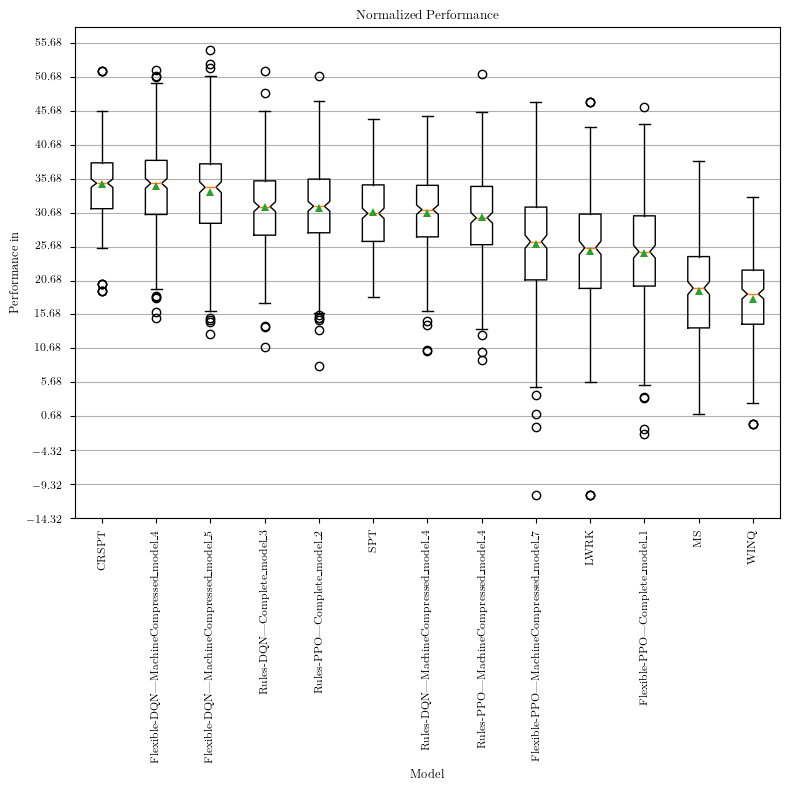

In [52]:
sub_models = tournament[tournament['candidate'].isin(target_models)].copy()
sub_models = pd.concat([sub_models, static_rules[static_rules['candidate'].isin(['WINQ', 'MS', 'SPT', 'LWRK', 'FIFO', 'CRSPT'])]])

performances = plot_normalized_performance(
    sub_models,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=candidates(sub_models),
        baseline='FIFO',
        ncols=1,
        # bottom=0,
        sort=True,
        # bbox_to_anchor =
        figsize=(8, 8)
    ),
    # ax=axes[1]
)

In [102]:
# df = pd.DataFrame()

# for name, candidate in performances:

#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../Final/graph_eval/output_best.tex' )
# ! (cp 'Testing/dataset.csv' 'Final/graph_eval/output_best.csv')
# ! (cd 'Final/graph_eval' && pdflatex -interaction=nonstopmode 'output_best.tex' > /dev/null)

## Best

['CRSPTSchedulingRule' 'CRSchedulingRule' 'ATCSchedulingRule'
 'MSSchedulingRule' 'WINQSchedulingRule' 'FIFOSchedulingRule'
 'MODSchedulingRule' 'DPTWINQNPTSchedulingRule' 'LWRKSchedulingRule'
 'SPTSchedulingRule' 'MR-S-P-O-MR' 'I-GINv2-M-C-DQN' 'MR-S-N-O-MR'
 'I-GATv2-M-C-DQN' 'AS-GDT-N-O-E']


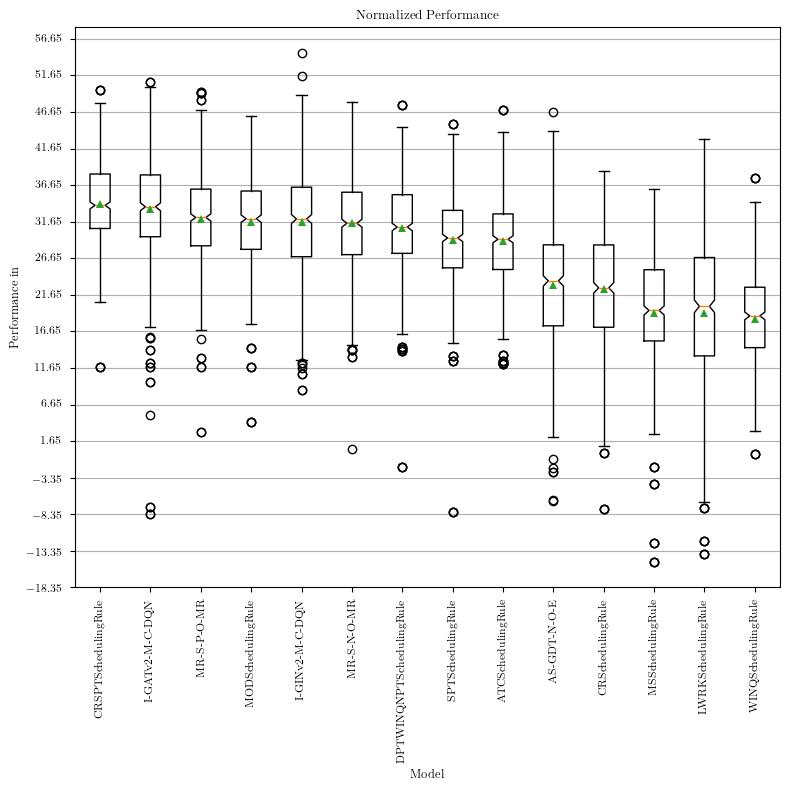

In [54]:
def load_tournament_from_id(i):
    t = load_tournament(f'data/4. Best/tournament/{i}/rules')
    # t['candidate'] = t['candidate'].str.replace('Local', 'MachineCompressed')
    # t['candidate'] = t['candidate'].str.replace('Global', 'Complete')


    mask = t['candidate'].str.contains('SchedulingRule')
    t['candidate'] = t['candidate'].str.split('_').apply(lambda x: x[0]).str.strip('|')

    # t.loc[mask, 'candidate'] = t.loc[mask, 'candidate'].str.extract(r'(.*)SchedulingRule$')
    t['run'] += 200 * (i-1)
    return t

tournament = [load_tournament_from_id(i) for i in range(1, 4)]
tournament = pd.concat(tournament)

print(tournament.candidate.unique())

# sub_models = pd.concat([sub_models, baseline[baseline['candidate'] == '|(0) NN|Baseline_model_0']])

performances = plot_normalized_performance(
    tournament,
    info=dict(
        title='Normalized Performance',
        xlabel='Model',
        ylabel='Performance in %',
        index='run',
        metric='tardiness',
        candidate_column='candidate',
        candidates=tournament['candidate'].unique(),
        baseline='FIFOSchedulingRule',
        ncols=1,
        # bottom=0,
        sort=True,
        # bbox_to_anchor =
        figsize=(8, 8)
    ),
    # ax=axes[1]
)

In [104]:
# df = pd.DataFrame()

# for name, candidate in performances:
#     name = name.replace('_', '-').replace(',', '')
#     df[name] = candidate

# print(df.isna().sum())

# #The method doesn't rank negative measures correctly
# df = (df - df.values.mean()) / df.values.std(ddof=1)
# df = df - df.values.min()

# df.to_csv('Testing/dataset.csv')

# ! (cd Testing && java Friedman 'dataset.csv'> '../Best/eval/output_best.tex' )
# ! (cp 'Testing/dataset.csv' 'Best/eval/output_best.csv')
# ! (cd 'Best/eval' && pdflatex -interaction=nonstopmode 'output_best.tex' > /dev/null)